In [1]:
import os, numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import wfdb, scipy.signal
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1) CONFIG
# =========================
DATA_DIR = "/mnt/d/ECG_AI/arrhythmia"    # đổi lại đúng đường dẫn
TARGET_FS = 125                        # resample về 125Hz
TARGET_LEN = 250                       # số điểm mẫu/nhịp
VAL_METRIC_AVG = "macro"               # macro F1

# 5 lớp theo bài báo
LABELS_KEEP = {'N':0, 'L':1, 'R':2, 'V':3, 'A':4}
IDX2NAME = {0:'N', 1:'LBBB', 2:'RBBB', 3:'PVC', 4:'APB'}

# =========================
# 2) Hàm tiền xử lý
# =========================
def resample_sig(sig, fs_from, fs_to=TARGET_FS, fixed_len=TARGET_LEN):
    sig = scipy.signal.resample(sig, int(len(sig) * fs_to / fs_from))
    if len(sig) > fixed_len:
        sig = sig[:fixed_len]
    elif len(sig) < fixed_len:
        sig = np.pad(sig, (0, fixed_len - len(sig)))
    return sig

def normalize_seg(seg):
    """
    Chuẩn hóa từng segment ECG theo z-score:
    (x - mean) / std, thực hiện riêng cho từng kênh.
    
    Input:
        seg: numpy array shape (len, channels)
    Output:
        seg_norm: numpy array cùng shape
    """
    m = seg.mean(axis=0, keepdims=True)   # mean theo từng kênh
    s = seg.std(axis=0, keepdims=True) + 1e-6  # std theo từng kênh (tránh chia 0)
    seg_norm = (seg - m) / s
    return seg_norm

def build_dataset(data_dir):
    X, y, recids = [], [], []
    records = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.hea')]
    records = sorted(list(set(records)))
    print("Loading records:", len(records))

    for rec in records:
        rec_path = os.path.join(data_dir, rec)
        rec_data = wfdb.rdrecord(rec_path)
        ann = wfdb.rdann(rec_path, 'atr')

        sig = rec_data.p_signal[:, :2]   # lấy 2 kênh: MLII và V1
        fs = int(rec_data.fs)

        sym, idx = np.array(ann.symbol), np.array(ann.sample)
        for i, s in enumerate(sym):
            if s not in LABELS_KEEP: 
                continue
            start = idx[i] - int(0.2*fs)
            end   = idx[i] + int(0.6*fs)
            if start < 0 or end > len(sig):
                continue
            seg = sig[start:end, :]
            seg_resampled = []
            for ch in range(2):
                seg_ch = resample_sig(seg[:, ch], fs, TARGET_FS, TARGET_LEN)
                seg_resampled.append(seg_ch)
            seg_resampled = np.stack(seg_resampled, axis=-1)  # (len, 2)
            X.append(seg_resampled)
            seg_norm = normalize_seg(seg_resampled) 
            y.append(LABELS_KEEP[s])
            recids.append(rec)

    return np.array(X), np.array(y), np.array(recids)  # shape (N, len, 2)

# =========================
# 3) Model: CNN + BiLSTM
# =========================
from tensorflow.keras import layers, models

def DeepArr(input_shape=(250,2), num_classes=5):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    for _ in range(2):
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.1)(x)

    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="DeepArr")

# =========================
# 4) Load dataset
# =========================
X, y, recids = build_dataset(DATA_DIR)
print("Dataset shape:", X.shape, y.shape)
print("Class distribution:", Counter(y))

Loading records: 48
Dataset shape: (100022, 250, 2) (100022,)
Class distribution: Counter({0: 75021, 1: 8072, 2: 7255, 3: 7129, 4: 2545})


In [ ]:
# 5) Train: Beat-level split
# =========================
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

all_acc, all_f1m, all_true, all_pred = [], [], [], []

save_dir = "/mnt/d/ECG_AI/model_norm"
os.makedirs(save_dir, exist_ok=True)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n========== FOLD {fold}/10 ==========")
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    y_tr_oh = tf.keras.utils.to_categorical(y_tr, num_classes=5)
    y_va_oh = tf.keras.utils.to_categorical(y_va, num_classes=5)

    model = DeepArr(input_shape=X.shape[1:], num_classes=5)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(save_dir, f"DeepArr_best_fold{fold}.h5"),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        X_tr, y_tr_oh,
        batch_size=64,
        epochs=30,
        validation_data=(X_va, y_va_oh),
        callbacks=callbacks,
        verbose=1
    )

    # Predict
    y_pred = np.argmax(model.predict(X_va, verbose=0), axis=1)
    acc = np.mean(y_pred == y_va)
    f1m = f1_score(y_va, y_pred, average=VAL_METRIC_AVG, zero_division=0)

    all_acc.append(acc)
    all_f1m.append(f1m)
    all_true.extend(y_va.tolist())
    all_pred.extend(y_pred.tolist())

    print("Fold Acc:", acc, "Fold F1:", f1m)
    print(confusion_matrix(y_va, y_pred))
    print(classification_report(
        y_va, y_pred,
        labels=[0,1,2,3,4],
        target_names=[IDX2NAME[i] for i in range(5)],
        zero_division=0
    ))

    # 👉 Lưu model cuối cùng của fold
    model.save(os.path.join(save_dir, f"DeepArr_last_fold{fold}.h5"))

# =========================
# 6) Summary
# =========================
print("\n=========== KẾT QUẢ TỔNG ===========")
print("ACC:", np.mean(all_acc), "±", np.std(all_acc))
print("F1 :", np.mean(all_f1m), "±", np.std(all_f1m))



========== FOLD 1/10 ==========
Epoch 1/30
1407/1407 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9596
Epoch 1: val_accuracy improved from -inf to 0.98241, saving model to /mnt/d/ECG_AI/model_norm/DeepArr_best_fold1.h5
1407/1407 [==============================] - 62s 37ms/step - loss: 0.1461 - accuracy: 0.9596 - val_loss: 0.0704 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 2/30
1406/1407 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9824
Epoch 2: val_accuracy improved from 0.98241 to 0.98900, saving model to /mnt/d/ECG_AI/model_norm/DeepArr_best_fold1.h5
1407/1407 [==============================] - 48s 34ms/step - loss: 0.0667 - accuracy: 0.9824 - val_loss: 0.0440 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 3/30
1406/1407 [============================>.] - ETA: 0s - loss: 0.0433 - accuracy: 0.9885
Epoch 3: val_accuracy did not improve from 0.98900
1407/1407 [==============================] - 46s 33ms/step - loss: 0.0433 - accuracy: 0.988

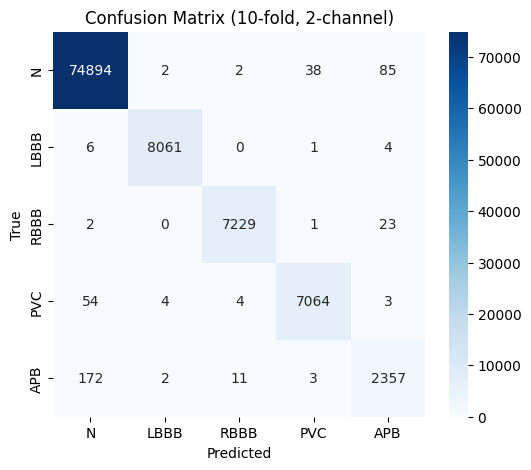

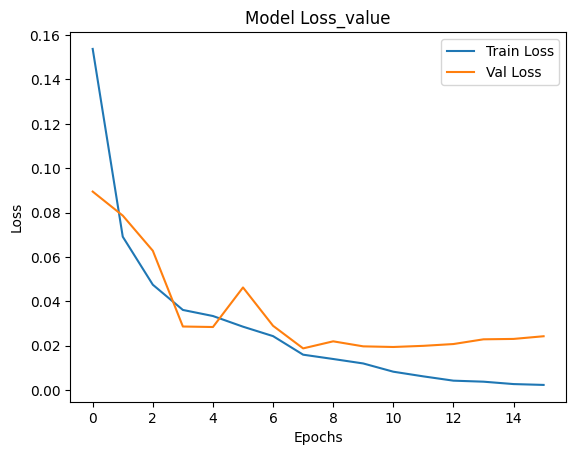

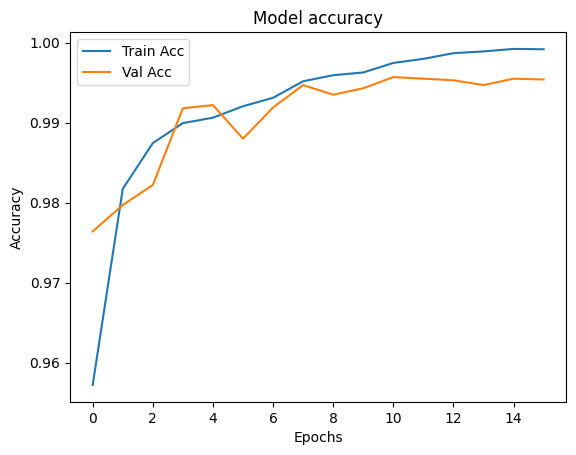

In [52]:
import json
# 7) Confusion matrix tổng hợp và biểu đồ train/loss
# =========================
np.save(os.path.join("/mnt/d/ECG_AI", f"all_true_fold.npy"), all_true)
np.save(os.path.join("/mnt/d/ECG_AI", f"all_pred_fold.npy"), all_pred)

# Load dữ liệu đã lưu
y_true = np.load("/mnt/d/ECG_AI/all_true_fold.npy")
y_pred = np.load("/mnt/d/ECG_AI/all_pred_fold.npy")

cm = confusion_matrix(all_true, all_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[IDX2NAME[i] for i in range(5)],
            yticklabels=[IDX2NAME[i] for i in range(5)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (10-fold, 2-channel)")
plt.show()


# Lưu history
def save_history(history, save_path):
    # convert numpy -> float
    hist_clean = {k: [float(x) for x in v] for k, v in history.history.items()}
    with open(save_path, "w") as f:
        json.dump(hist_clean, f)

# Load lại
def load_history(load_path):
    with open(load_path, "r") as f:
        hist = json.load(f)
    return hist

save_path = os.path.join("/mnt/d/ECG_AI", f"history_fold.json")
save_history(history, save_path)

hist = load_history("/mnt/d/ECG_AI/history_fold.json")

plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title("Model Loss_value")
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label='Train Acc')
plt.plot(hist['val_accuracy'], label='Val Acc')
plt.title("Model accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [3]:
# 9) DỰ ĐOÁN TOÀN BỘ ECG + SLIDER
# =========================
import ipywidgets as widgets
from ipywidgets import interact

# --- Cắt nhịp quanh vị trí annotation (0.2s trước + 0.6s sau) ---
"""
Input:
sig: tín hiệu ECG (một/hai kênh).
idx_keep: danh sách vị trí R-peak từ annotation (WFDB .atr).
fs: tần số lấy mẫu.
pre, post: khoảng thời gian trích trước và sau R-peak.

Output:
rr_segs: danh sách (start, end) cho từng nhịp → tức là cắt ra đoạn tín hiệu “quanh R-peak”.
valid_idx: index các nhịp hợp lệ (không bị out of bounnd)."""
def rr_segments_from_annotations(sig, idx_keep, fs, pre=0.2, post=0.6):
    rr_segs, valid_idx = [], []
    for i, idx in enumerate(idx_keep):
        start = idx - int(pre*fs)
        end   = idx + int(post*fs)
        if start < 0 or end > len(sig):
            continue
        rr_segs.append((start,end))
        valid_idx.append(i)
    return rr_segs, valid_idx

# --- Resample segment nhiều kênh về độ dài cố định ---
"""
Input:
sig: tín hiệu ECG (một kênh).
idx_keep: danh sách vị trí R-peak từ annotation (WFDB .atr).
fs: tần số lấy mẫu.
pre, post: khoảng thời gian trích trước và sau R-peak.

Output:
rr_segs: danh sách (start, end) cho từng nhịp → tức là cắt ra đoạn tín hiệu “quanh R-peak”.
valid_idx: index các nhịp hợp lệ (không bị out of bound)."""
def resample_to_fixed_multichan(seg, fs_from, fs_to=TARGET_FS, fixed_len=TARGET_LEN):
    seg_resampled = []
    for ch in range(seg.shape[1]):
        sig_ch = scipy.signal.resample(seg[:,ch], int(len(seg)*fs_to/fs_from))
        if len(sig_ch) > fixed_len:
            sig_ch = sig_ch[:fixed_len]
        elif len(sig_ch) < fixed_len:
            sig_ch = np.pad(sig_ch, (0, fixed_len-len(sig_ch)))
        seg_resampled.append(sig_ch)
    return np.stack(seg_resampled, axis=-1)  # (fixed_len,2)

# --- Hàm dự đoán tất cả beat trong 1 record ---
def predict_beats(record_path, model, N):
    rec = wfdb.rdrecord(record_path)

    if N is not None:
        sig = rec.p_signal[:N, :2]
        fs  = int(rec.fs)
    else:
        sig = rec.p_signal[ :, :2]
        fs  = int(rec.fs)

    ann = wfdb.rdann(record_path, 'atr')
    sym, idx = np.array(ann.symbol), np.array(ann.sample)

    keep = np.isin(sym, list(LABELS_KEEP.keys()))
    sym_keep, idx_keep = sym[keep], idx[keep]

    print("Tổng annotation:", len(sym))
    print("Số nhịp giữ lại:", len(sym_keep))
    print("Các symbol trong file:", set(sym))
    print("Các symbol được giữ:", set(sym_keep))

    segments, labels, pos = [], [], []
    rr_segs, valid_idx = rr_segments_from_annotations(sig[:,0], idx_keep, fs)

    for (s,e), i_sym in zip(rr_segs, valid_idx):
        X = resample_to_fixed_multichan(sig[s:e,:2], fs_from=fs,
                                        fs_to=TARGET_FS, fixed_len=TARGET_LEN)
        y = LABELS_KEEP[sym_keep[i_sym]]
        segments.append(X)
        labels.append(y)
        pos.append(idx_keep[i_sym])

    if not segments:
        return [], [], ([], [])

    X_test = np.array(segments)   # [N, 250, 2]
    probs  = model.predict(X_test, verbose=0)
    y_pred = probs.argmax(axis=1)
    conf   = probs.max(axis=1)

    return pos, np.array(labels), (y_pred, conf)
    

# --- Hàm vẽ ECG với thanh trượt (2 kênh) ---
def plot_ecg_with_slider(record_path, model, window_size=10, duration_sec=None):
    rec = wfdb.rdrecord(record_path)
    sig = rec.p_signal
    fs = int(rec.fs)
    lead_names = rec.sig_name   # tên lead gốc trong database

    # chỉ lấy một đoạn nhất định nếu duration_sec != None
    if duration_sec is not None:
        N = min(len(sig), int(duration_sec * fs))
        sig = sig[:N]
    else:
        N = None

    total_seconds = len(sig) // fs
    win_len = window_size * fs

    # chuẩn bị dự đoán toàn bộ record
    pos_all, y_true_all, (y_pred_all, conf_all) = predict_beats(record_path, model, N)

    def update(start_sec=0):
        start = int(start_sec * fs)
        end = start + win_len
        end = min(end, len(sig))

        fig, axes = plt.subplots(sig.shape[1], 1, figsize=(30, 10), sharex=True)
        if sig.shape[1] == 1:
            axes = [axes]

        for ch in range(sig.shape[1]):
            axes[ch].plot(np.arange(start, end)/fs, sig[start:end, ch], color="black")
            axes[ch].set_title(f"{lead_names[ch]} | {os.path.basename(record_path)} | Duration: {duration_sec}s @ {start_sec}-{start_sec+window_size}s")
            axes[ch].set_ylabel("Amplitude")

            y_min, y_max = np.min(sig[start:end,ch]), np.max(sig[start:end,ch])
            text_y = y_max * 0.8   # cố định chữ ở 80% biên độ max

            for i, beat_idx in enumerate(pos_all):
                if start <= beat_idx < end:
                    true_lbl = IDX2NAME[y_true_all[i]]
                    pred_lbl = IDX2NAME[y_pred_all[i]]
                    color = "green" if true_lbl == pred_lbl else "red"
                    conf = conf_all[i]

                    axes[ch].axvline(x=beat_idx/fs, color=color, linestyle="--", alpha=0.6)
                    axes[ch].text(
                        beat_idx/fs, text_y, f"T:{true_lbl}, P:{pred_lbl} ({conf:.2f})",
                        color=color, fontsize=10, ha='center', fontweight="bold",
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
                    )

        plt.xlabel("Time (s)")
        plt.show()

    interact(update, start_sec=widgets.IntSlider(min=0, max=total_seconds-window_size, step=1, value=0))



In [ ]:
# MIT-BIH Arrhythmia Dataset
# load tất cả fold
model_paths = [f"/mnt/d/ECG_AI/model/DeepArr_last_fold{i}.h5" for i in [1,2,3,4,5,6,7,8,9,10]]
avg_model = HybridEnsemble(model_paths)

TEST_DIR = "/mnt/d/ECG_AI/arrhythmia" 
# test record, cửa sổ 10 giây
plot_ecg_with_slider(os.path.join(TEST_DIR, "124"), avg_model, window_size=10, duration_sec=None)

Tổng annotation: 1634
Số nhịp giữ lại: 1580
Các symbol trong file: {'J', '+', 'j', 'R', 'F', 'A', '~', 'V'}
Các symbol được giữ: {'A', 'R', 'V'}


interactive(children=(IntSlider(value=0, description='start_sec', max=1795), Output()), _dom_classes=('widget-…

In [63]:
# Detecing QRS - Predict ECG
import numpy as np, matplotlib.pyplot as plt, ipywidgets as widgets
from ipywidgets import interact
from wfdb import processing
import scipy.signal as sp

IDX2NAME = {0:'N',1:'L',2:'R',3:'V',4:'A'}

def resample_fft_like_train(seg, fs_from, fs_to=125, fixed_len=250):
    out = []
    for ch in range(seg.shape[1]):
        y = sp.resample(seg[:, ch], int(len(seg)*fs_to/fs_from))  # FFT (như lúc train)
        if len(y) > fixed_len: y = y[:fixed_len]
        elif len(y) < fixed_len: y = np.pad(y, (0, fixed_len-len(y)))
        out.append(y)
    return np.stack(out, axis=-1)

def plot_ecg_with_slider_raw(sig, fs, model, window_size=10, pre=0.2, post=0.6):
    sig = np.asarray(sig, np.float32)
    if sig.ndim==1: sig = sig[:,None]
    # không bandpass, không z-score để khớp train
    total_seconds = len(sig)//fs
    win_len = window_size*fs

    def update(start_sec=0):
        start = int(start_sec*fs); end = min(start+win_len, len(sig))
        seg = sig[start:end,:]

        # QRS trong window
        xqrs = processing.XQRS(sig=seg[:,0], fs=fs)
        xqrs.detect()
        r = xqrs.qrs_inds

        refined = []
        for idx in r:
            win = seg[max(0,idx-int(0.05*fs)): min(len(seg),idx+int(0.05*fs))]
            if len(win)==0: continue
            local_peak = np.argmax(np.abs(win))
            refined.append(idx - int(0.05*fs) + local_peak)
        r = np.array(refined)

        # simple refractory 200ms để bớt đỉnh giả
        clean = []
        for x in r:
            if not clean or x-clean[-1] >= int(0.2*fs): clean.append(x)
        r = np.asarray(clean, int)

        plt.figure(figsize=(30,10))
        t = np.arange(start,end)/fs
        plt.plot(t, seg[:,0], color='black')
        plt.title(f"Raw ECG | window {window_size}s @ {start_sec}-{start_sec+window_size}s")
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude")

        for idx in r:
            beat_idx = start+idx
            s0 = beat_idx - int(pre*fs); e0 = beat_idx + int(post*fs)
            if s0<0 or e0>len(sig): continue
            beat = sig[s0:e0,:]
            beat = resample_fft_like_train(beat, fs_from=fs, fs_to=125, fixed_len=250)
            x = beat[None,...]  # (1,250,2) — đúng input model

            prob = model.predict(x, verbose=0)[0]
            cls  = int(prob.argmax()); conf = float(prob.max())
            lab  = IDX2NAME.get(cls, str(cls))
            col  = 'tab:green' if lab=='N' else 'tab:red'

            plt.axvline(beat_idx/fs, color=col, linestyle='--', alpha=0.7)
            ytxt = seg[idx,0]
            plt.text(beat_idx/fs, ytxt, f"P:{lab} ({conf:.2f})",
                     color=col, fontsize=8, ha='center', va='bottom')
        plt.show()

    interact(update, start_sec=widgets.IntSlider(min=0, max=max(total_seconds-window_size,0),
                                                 step=1, value=0))


In [64]:
# Show Predict with raw ECG
rec = wfdb.rdrecord("/mnt/d/ECG_AI/arrhythmia/200")
# lấy 5 phút - 
duration_sec = 300
fs = rec.fs
sig = rec.p_signal[:fs*duration_sec,:]

# load tất cả fold
model_paths = [f"/mnt/d/ECG_AI/model/DeepArr_last_fold{i}.h5" for i in [1,2,3,4,5,6,7,8,9,10]]
avg_model = HybridEnsemble(model_paths)

plot_ecg_with_slider_raw(sig, fs, avg_model, window_size=10)


interactive(children=(IntSlider(value=0, description='start_sec', max=290), Output()), _dom_classes=('widget-i…